### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import csv
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from sklearn.datasets import make_classification
from torch.utils.data import Dataset, TensorDataset, DataLoader
import lightkurve as lk
from scipy.optimize import curve_fit
import sys
import utils
import importlib
importlib.reload(utils)


/home/lzucker1/miniconda3/envs/general/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'utils' from '/mnt/c/Users/Lea/OneDrive/TransitClassification_2023/transit_classification/utils.py'>

### Download LC Data

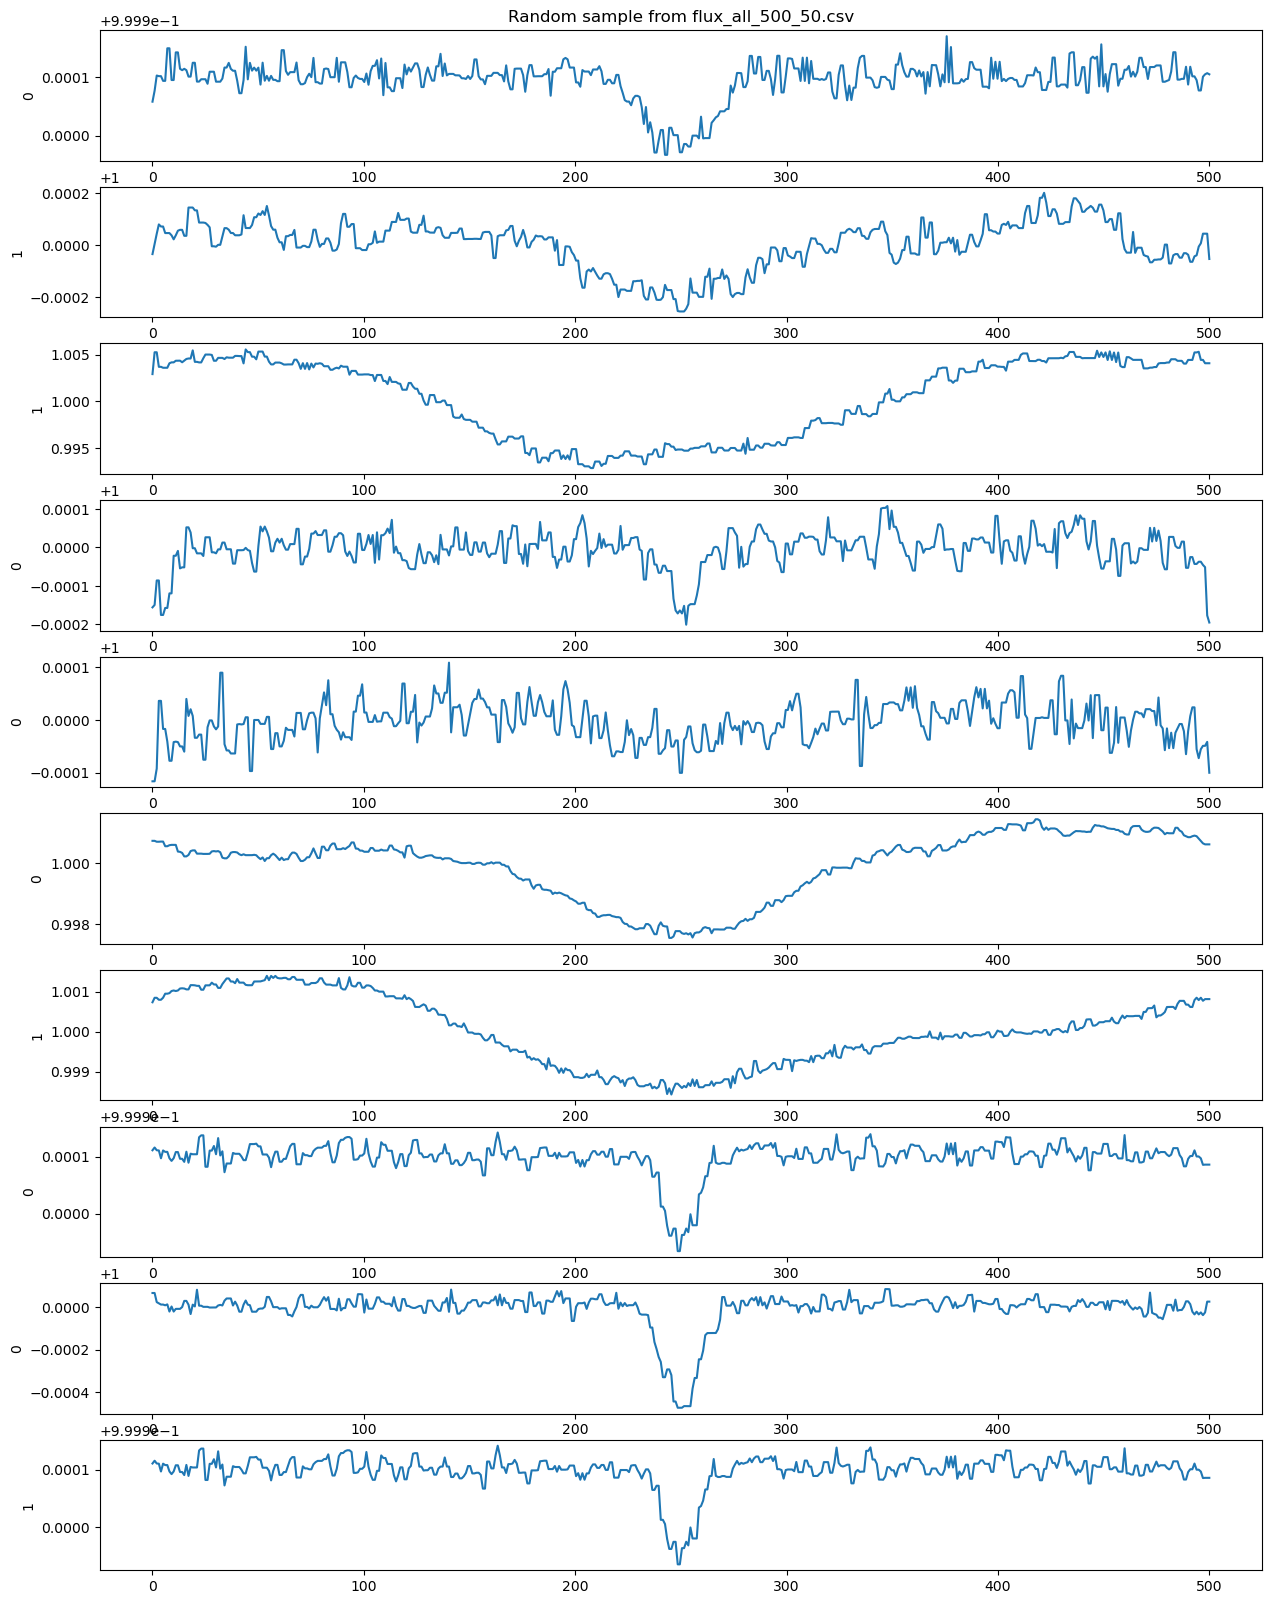

In [12]:
'''
Download via script to prevent notebook crashing
'''

folder = 'folded/'
tag = 'all_500_50'

data = pd.read_csv(f"../Data/{folder}flux_{tag}.csv", header=None)
labels = pd.read_csv(f"../Data/{folder}labels_{tag}.csv", header=None)
fig, axs = plt.subplots(10, 1, figsize=(15, 20))
axs[0].set_title(f'Random sample from flux_{tag}.csv')
for i in range(10):
    idx = np.random.randint(0, len(labels))
    flux = data.iloc[idx]
    #fluxnorm = ((data.iloc[idx] - np.nanmin(data.iloc[idx]))/(np.nanmax(data.iloc[idx]) - np.nanmin(data.iloc[idx])))
    axs[i].plot(np.linspace(0, 500, 500), flux) #label=labels.iloc[i][0]); 
    axs[i].set_ylabel(f'{labels.iloc[i][0]}')
plt.savefig(f'../test_foldedcurves')

### Implement NN

In [39]:
'''
Try with normal feed-foward NN using fluxes as features
  - NN1 = trained on full lightcurves
  - NN2 = trained on folded lightcurves
'''

import importlib
importlib.reload(utils)

X_path = "../Data/folded/flux_all_500_50.csv" #"../Data/flux_all_1000_50.csv" # 
y_path =  "../Data/folded/labels_all_500_50.csv" # "../Data/labels_all_1000_50.csv" #
input_dim = 500
n_nodes = [60, 20] # n nodes in hidden layers
n_classes = 2 
name = 'NN2'

# Load in data and make into train and testloaders
X = pd.read_csv(X_path, header=None).to_numpy() 
Y = pd.read_csv(y_path, header=None).to_numpy()

# nanrows = X[X.isnull().all(axis=1)].index
# print(nanrows)
# a=b

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
batch_size = 5
n_batches = int(len(X_train)/batch_size)
train_ds = utils.MyDataset(X_train, Y_train, norm=True, impute_nans=True)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_ds = utils.MyDataset(X_test, Y_test, norm=True, impute_nans=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)
utils.check_inputs(train_ds, train_loader)

# Define model, loss function and optimizer
model = utils.LinearNN(input_dim, n_classes, n_nodes)
print(f'Model:\t {model}')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 

# Train
epochs = 3
print('Training')
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data # one batch    # if torch.any(torch.isnan(inputs)): print('inputs contains nan'); a=b
    optimizer.zero_grad()
    outputs = model(inputs) # Raw outputs. To get class probs, apply act func. Then argmax to get preds.
    loss = loss_fn(outputs, labels)#.long()) # for CEL, outputs must be float, labels long?
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f'\tEpoch {epoch} approx avg loss per batch of {batch_size} obs: {running_loss/n_batches:.5f}')

# Save the trained NN
torch.save(model.state_dict(), f'../{name}.pth')

# Read it back in 
model = utils.LinearNN(input_dim, n_classes, n_nodes)
model.load_state_dict(torch.load(f'../{name}.pth'))

# Test 
print('Validating')
accuracy = utils.validate(val_loader, model)
print(f"\tGot accuracy {accuracy:.2f}%")

Train data:
     446 obs, broken into 90 batches
     Each batch has data of shape torch.Size([5, 1, 500]), e.g. 5 obs, 500 pixels, 1 feature channels
     Each batch has labels of shape torch.Size([5, 2]), e.g. 5 obs, 2 classes
Model:	 LinearNN(
  (layers): ModuleList(
    (0): Linear(in_features=500, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=2, bias=True)
  )
)
Training
	Epoch 0 approx avg loss per batch of 5 obs: 0.71672
	Epoch 1 approx avg loss per batch of 5 obs: 0.69921
	Epoch 2 approx avg loss per batch of 5 obs: 0.69686
Validating
	Got accuracy 53.39%


In [49]:
x = torch.tensor([1, 1, 1, float('nan'), 1, 1])
x = ((x - np.nanmin(x))/(np.nanmax(x) - np.nanmin(x))) 
print(x)
#if torch.any(torch.isnan(inputs)): print('yes')

tensor([nan, nan, nan, nan, nan, nan])


In [42]:
'''
Convolutional (1D) NNs, 1 channel
  - NN3 = trained on full lightcurves
  - NN4 = trained on folded lightcurves
'''

import utils
import importlib
importlib.reload(utils)

X_path = "../Data/folded/flux_all_500_50.csv" #"../Data/flux_200_1000_50.csv"
y_path = "../Data/folded/labels_all_500_50.csv" #"../Data/labels_200_1000_50.csv"
input_dim = 1 
n_classes = 2 
in_samples = 500 # 1000
n_channels = [64, 128, 256] 
n_samples = [1000, 200] # [2000, 500]
name = 'CNNb'

# Load in data and make into train and testloaders
X = pd.read_csv(X_path, header=None).to_numpy() 
Y = pd.read_csv(y_path, header=None).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
batch_size = 5
n_batches = int(len(X_train)/batch_size)
train_ds = utils.MyDataset(X_train, Y_train, norm=True, impute_nans=True)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_ds = utils.MyDataset(X_test, Y_test, norm=True, impute_nans=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)
utils.check_inputs(train_ds, train_loader)

# Define model, loss function and optimizer
model = utils.ConvNN3(input_dim, n_classes, channels=n_channels, in_samps=in_samples, samps=n_samples)
print(f'Model:\n {model}')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 

# Train
epochs = 5
print('Training')
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs) # Raw outputs. To get class probs, apply act func. Then argmax to get preds.
    loss = loss_fn(outputs, labels)#.long()) # for CEL,f outputs must be float, labels long?
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f'\tEpoch {epoch} approx avg loss per batch of {batch_size} obs: {running_loss/n_batches:.5f}')

# Save the trained NN
torch.save(model.state_dict(), f'../{name}.pth')

# Read it back in 
model = utils.ConvNN3(input_dim, n_classes, channels=n_channels, in_samps=in_samples, samps=n_samples)
model.load_state_dict(torch.load(f'../{name}.pth'))

# Test
print('Validating')
accuracy = utils.validate(val_loader, model)
print(f"\tGot accuracy {accuracy:.2f}%")



Train data:
     446 obs, broken into 90 batches
     Each batch has data of shape torch.Size([5, 1, 500]), e.g. 5 obs, 500 pixels, 1 feature channels
     Each batch has labels of shape torch.Size([5, 2]), e.g. 5 obs, 2 classes
Model:
 ConvNN3(
  (convs): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): ReLU()
    (7): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): ReLU()
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linears): ModuleList(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32000, out_features=1000, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=

In [56]:
'''
Convolutional (1D) NNs, 2 channels
  - NN5 = trained on full lightcurves and time steps
  - NN6 = trained on folded lightcurves and phase steps
'''

import utils
import importlib
importlib.reload(utils)

X1_path = "../Data/folded/flux_all_500_50.csv" #"../Data/flux_200_1000_50.csv"
X2_path = "../Data/folded/time_all_500_50.csv" #"../Data/time_200_1000_50.csv"
y_path = "../Data/folded/labels_all_500_50.csv" #"../Data/labels_200_1000_50.csv"
input_dim = 2
n_classes = 2 
in_samples = 500 # 1000
n_channels = [64, 128, 256] 
n_samples = [1000, 200] # [2000, 500]
name = 'NN6'

# Load in data and make into train and testloaders
X1 = pd.read_csv(X1_path, header=None).to_numpy() 
X2 = pd.read_csv(X2_path, header=None).to_numpy() 
Y = pd.read_csv(y_path, header=None).to_numpy()
X1_train, X1_test, X2_train, X2_test, Y_train, Y_test = train_test_split(X1, X2, Y, test_size=0.33, random_state=42)
batch_size = 5
train_ds = utils.MyDataset(X1_train, Y_train, X2_train, norm=True, impute_nans=True)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_ds = utils.MyDataset(X1_test, Y_test, X2_test, norm=True, impute_nans=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)
utils.check_inputs(train_ds, train_loader)

# Define model, loss function and optimizer
model = utils.ConvNN3(input_dim, n_classes, channels=n_channels, in_samps=in_samples, samps=n_samples)
print(f'Model:\n {model}')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 

# Train
epochs = 5
print('Training')
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs) # Raw outputs. To get class probs, apply act func. Then argmax to get preds.
    loss = loss_fn(outputs, labels)#.long()) # for CEL,f outputs must be float, labels long?
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f'\tEpoch {epoch} approx avg loss per batch of {batch_size} obs: {running_loss/n_batches:.5f}')

# Save the trained NN
torch.save(model.state_dict(), f'../{name}.pth')

# Read it back in 
model = utils.ConvNN3(input_dim, n_classes, channels=n_channels, in_samps=in_samples, samps=n_samples)
model.load_state_dict(torch.load(f'../{name}.pth'))

# Test
print('Validating')
accuracy, dice_score = utils.validate(val_loader, model)
print(f"\tGot accuracy {accuracy:.2f}%")


Train data:
     446 obs, broken into 90 batches
     Each batch has data of shape torch.Size([5, 2, 500]), e.g. 5 obs, 500 pixels, 2 feature channels
     Each batch has labels of shape torch.Size([5, 2]), e.g. 5 obs, 2 classes
Model:
 ConvNN3(
  (convs): ModuleList(
    (0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): ReLU()
    (7): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): ReLU()
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linears): ModuleList(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32000, out_features=1000, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=200, bias=True)
    

In [61]:
'''
LSTM NN
  - NN7 = trained on folded lightcurves
'''

import utils
import importlib
importlib.reload(utils)

X_path = "../Data/folded/flux_all_500_50.csv" #"../Data/flux_200_1000_50.csv"
y_path = "../Data/folded/labels_all_500_50.csv" #"../Data/labels_200_1000_50.csv"
input_dim = 1
n_classes = 2 
in_samples = 500 # 1000
n_channels = [60] 
n_samples = [1000, 200] # [2000, 500]
name = 'NN7'

# Load in data and make into train and testloaders
X = pd.read_csv(X_path, header=None).to_numpy() 
Y = pd.read_csv(y_path, header=None).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
batch_size = 5
train_ds = utils.MyDataset(X_train, Y_train, norm=True, impute_nans=True)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_ds = utils.MyDataset(X_test, Y_test, norm=True, impute_nans=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)
utils.check_inputs(train_ds, train_loader)

# Define model, loss function and optimizer
model = utils.LSTM(input_dim, n_classes, channels=n_channels, in_samps=in_samples, samps=n_samples)
print(f'Model:\n {model}')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 

# Train
epochs = 5
print('Training')
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs) # Raw outputs. To get class probs, apply act func. Then argmax to get preds.
    loss = loss_fn(outputs, labels)#.long()) # for CEL,f outputs must be float, labels long?
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f'\tEpoch {epoch} approx avg loss per batch of {batch_size} obs: {running_loss/n_batches:.5f}')

# Save the trained NN
torch.save(model.state_dict(), f'../{name}.pth')

# Read it back in 
model = utils.LSTM(input_dim, n_classes, channels=n_channels, in_samps=in_samples, samps=n_samples)
model.load_state_dict(torch.load(f'../{name}.pth'))

# Test
print('Validating')
accuracy = utils.validate(val_loader, model)
print(f"\tGot accuracy {accuracy:.2f}%")


Train data:
     460 obs, broken into 92 batches
     Each batch has data of shape torch.Size([5, 1, 500]), e.g. 5 obs, 500 pixels, 1 feature channels
     Each batch has labels of shape torch.Size([5, 2]), e.g. 5 obs, 2 classes
Model:
 LSTM(
  (lstm): LSTM(1, 60, num_layers=3, batch_first=True)
  (linears): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=30000, out_features=1000, bias=True)
    (2): Linear(in_features=1000, out_features=200, bias=True)
    (3): Linear(in_features=200, out_features=2, bias=True)
  )
)
Training
	Epoch 0 loss: 0.03248
	Epoch 1 loss: 0.03211
	Epoch 2 loss: 0.03205
	Epoch 3 loss: 0.03205
	Epoch 4 loss: 0.03203
	Epoch 5 loss: 0.03204
	Epoch 6 loss: 0.03212
	Epoch 7 loss: 0.03213
Validating
	Got accuracy 50.66%


In [ ]:
'''
Other 
    - Try to replicate CNN from Zucker and Giryes (2018) (Still features are just fluxes, no times)
    - Want to be pass in the information about the time of each flux, not just the order - ALTHOUGH LOOKS LIKE PREV WORK DOESNT DO THAT??
    - RNN <----- THIS
    - LSTM: can be used for time-series classification as well time-series prediction (predict next value)
      BUT typically better for long-term trends, which I dont think we actually want - might even pick up unwanted trends.
    - Could also try using both time-series and FT data - for example something like https://www.kaggle.com/code/purplejester/pytorch-deep-time-series-classification
'''